# Remapping of bed machine Antarctica 1

Coordinates is given in meters in a polar stereographic coordinate reference system. We need to create the corresponding longitude/latitude arrays using the PROJ library.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt

The PROJ string is available here: 
    
https://nsidc.org/data/NSIDC-0756/versions/1

In [2]:
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

Open the orginal dataset:

In [3]:
topo_raw = xr.open_dataset('BedMachineAntarctica_2019-11-05_v01.nc')

In [4]:
topo_raw

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes:
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     05-Nov-2019 (v1.38)
    nx:                          13333.0
    ny:                          13333.0
    Projection:                  Polar Stereographic South (71S,0E)
    proj4:                       +init=epsg:3031
    sea_water_density (kg m-3):  1027.0
    ice_density (kg m-3):        917.0
    xmin:                        -3333000
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

Now compute the longitude and latitude using the inverse transformation from the CRS:

In [5]:
def add_lon_lat(ds, PROJSTRING, x='x', y='y', chunks={}):
    """ add longitude and latitude as compute from the inverse projection
    given in PROJSTRING
    
    PARAMETERS:
    -----------
    ds: xarray.Dataset
    
    PROJSTRING: str
    
    """
    from pyproj import CRS, Transformer
    # create the coordinate reference system
    crs = CRS.from_proj4(PROJSTRING)
    # create the projection from lon/lat to x/y
    proj = Transformer.from_crs(crs.geodetic_crs, crs)
    # make x,y 2d arrays
    xx, yy = np.meshgrid(ds[x].values, ds[y].values)
    # compute the lon/lat
    lon, lat = proj.transform(xx, yy, direction='INVERSE')
    # add to dataset
    ds['lon'] = xr.DataArray(data=lon, dims=('y', 'x'))
    ds['lat'] = xr.DataArray(data=lat, dims=('y', 'x'))
    return ds

In [6]:
%%time
#this should take a couple of minutes
topo_raw = add_lon_lat(topo_raw, PROJSTRING)

CPU times: user 1min 59s, sys: 370 ms, total: 1min 59s
Wall time: 1min 59s


In [7]:
topo_raw

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int64 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int64 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 b''
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    geoid      (y, x) int16 ...
    lon        (y, x) float64 -45.0 -45.0 -44.99 -44.99 ... 135.0 135.0 135.0
    lat        (y, x) float64 -48.46 -48.47 -48.47 ... -48.47 -48.47 -48.46
Attributes:
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     05-Nov-2019 (v1.38)
    nx:                          13333.0
    ny:                          13333.0
    Projection:                  Polar Stereographic South (71S,0E)
    proj4:                       +init=epsg:3031
    sea_water_density (kg m-3):  1027.0
    ice_density (kg m-3):        917.0
    xmin:                        -3333000
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

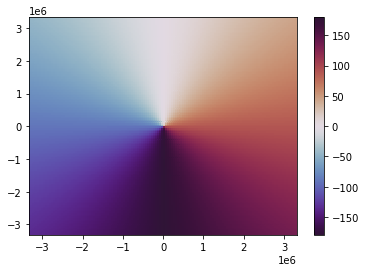

In [8]:
plt.pcolormesh(topo_raw.x.values[::100],
               topo_raw.y.values[::100],
               topo_raw.lon.values[::100, ::100],
               cmap='twilight_shifted')
plt.colorbar()

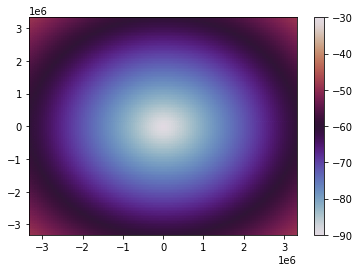

In [9]:
plt.pcolormesh(topo_raw.x.values[::100],
               topo_raw.y.values[::100],
               topo_raw.lat.values[::100,::100],
               cmap='twilight', vmin=-90, vmax=-30)
plt.colorbar()

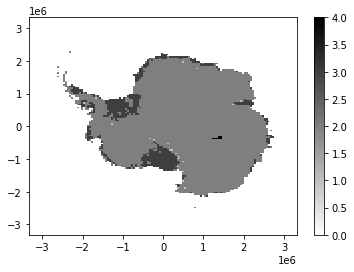

In [10]:
plt.pcolormesh(topo_raw.x.values[::100],
               topo_raw.y.values[::100],
               topo_raw.mask.values[::100,::100],
               cmap='binary')
plt.colorbar()

In [11]:
coarse_lon = topo_raw.lon.isel(x=slice(0,13300),
                               y=slice(0,13300)).coarsen(x=10,
                                                         y=10).median()
coarse_lat = topo_raw.lat.isel(x=slice(0,13300),
                               y=slice(0,13300)).coarsen(x=10,
                                                         y=10).median()

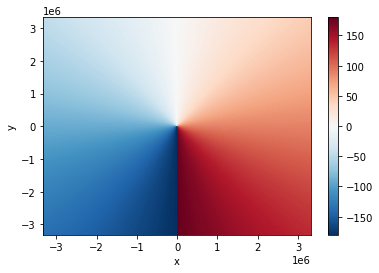

In [12]:
coarse_lon.plot()

In [13]:
coarse_topo = topo_raw.bed.isel(x=slice(0,13300),
                                y=slice(0,13300)).coarsen(x=10,
                                                          y=10).median()

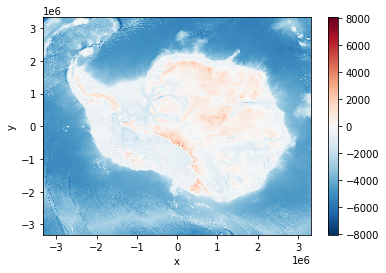

In [14]:
coarse_topo.plot()

In [15]:
coarse_topo_rough = topo_raw.bed.isel(x=slice(0,13300),
                                      y=slice(0,13300)).coarsen(x=10,
                                                                y=10).std()

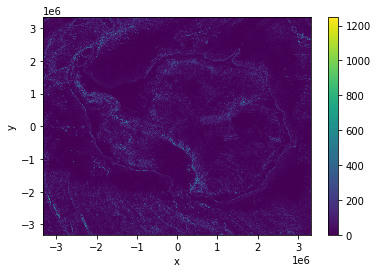

In [16]:
coarse_topo_rough.plot()

In [17]:
topo_coarsen = xr.Dataset()
topo_coarsen['lon'] = coarse_lon
topo_coarsen['lat'] = coarse_lat
topo_coarsen['topo'] = coarse_topo
topo_coarsen['h2'] = coarse_topo_rough

In [18]:
topo_coarsen

<xarray.Dataset>
Dimensions:  (x: 1330, y: 1330)
Coordinates:
  * x        (x) float64 -3.331e+06 -3.326e+06 ... 3.309e+06 3.314e+06
  * y        (y) float64 3.331e+06 3.326e+06 3.321e+06 ... -3.309e+06 -3.314e+06
Data variables:
    lon      (y, x) float64 -45.0 -44.96 -44.91 -44.87 ... 135.1 135.0 135.0
    lat      (y, x) float64 -48.49 -48.52 -48.55 -48.58 ... -48.74 -48.71 -48.68
    topo     (y, x) float32 -5923.491 -5953.502 ... -3564.1826 -3600.6265
    h2       (y, x) float32 17.839201 12.422138 ... 11.030463 18.059723

In [19]:
datasetdir = '/archive/Raphael.Dussin/datasets/'
dirgrid = f'{datasetdir}/OM4p125/OM4p125_grid_20200213_merged_bathy_unpacked/'
hgrid = f'{dirgrid}/ocean_hgrid.nc'

In [20]:
supergrid = xr.open_dataset(hgrid)

In [21]:
supergrid

<xarray.Dataset>
Dimensions:   (nx: 5760, nxp: 5761, ny: 4480, nyp: 4481)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    tile      |S255 ...
    y         (nyp, nxp) float64 ...
    x         (nyp, nxp) float64 ...
    dy        (ny, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    area      (ny, nx) float64 ...
    angle_dx  (nyp, nxp) float64 ...
Attributes:
    history:      This grid file was generated via command /work/Niki.Zadeh/g...
    description:  This is an orthogonal coordinate grid for the Earth with a ...
    source:       /work/Niki.Zadeh/grid_generation/ocean_grid_generator.py ha...

Create a grid dataset for the southern ocean

In [22]:
grid = xr.Dataset()

grid['lon'] = xr.DataArray(data=supergrid['x'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))
grid['lat'] = xr.DataArray(data=supergrid['y'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))
grid['dx'] = xr.DataArray(data=supergrid['dx'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))
grid['dy'] = xr.DataArray(data=supergrid['dy'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))

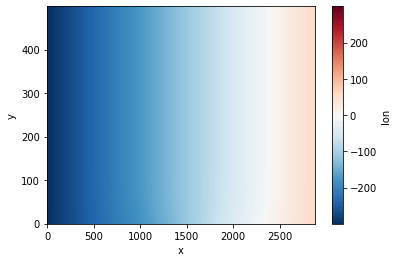

In [23]:
grid['lon'].plot()

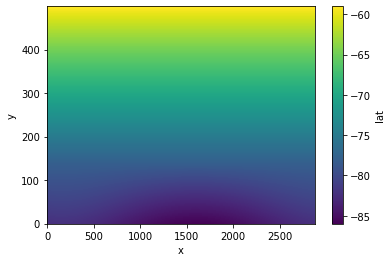

In [24]:
grid['lat'].plot()

In [25]:
import xesmf

In [26]:
%%time

regrid = xesmf.Regridder(topo_coarsen, grid, method='nearest_s2d', periodic=True)

/net2/rnd/anaconda3/envs/analysis/lib/python3.6/site-packages/xesmf-0.1.1-py3.6.egg/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.


Overwrite existing file: nearest_s2d_1330x1330_500x2880_peri.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 12.4 s, sys: 686 ms, total: 13.1 s
Wall time: 13.1 s


In [27]:
%%time

topo_regrid = regrid(topo_coarsen['topo'])

CPU times: user 13.3 ms, sys: 2.98 ms, total: 16.3 ms
Wall time: 14.7 ms


In [28]:
%%time

topo_regrid.load()

CPU times: user 169 µs, sys: 4 µs, total: 173 µs
Wall time: 182 µs


<xarray.DataArray 'topo' (y: 500, x: 2880)>
array([[  743.3527832 ,   743.3527832 ,   745.91015625, ...,
          718.00292969,   718.00292969,   718.00292969],
       [  721.74816895,   721.74816895,   745.91015625, ...,
          689.17626953,   721.74816895,   721.74816895],
       [  732.56530762,   732.56530762,   732.56530762, ...,
          697.83129883,   697.83129883,   697.83129883],
       ...,
       [-4925.13867188, -4958.31445312, -4955.15234375, ...,
        -4980.67871094, -4970.48193359, -4932.22900391],
       [-4935.40673828, -4962.78417969, -4969.70947266, ...,
        -5044.41699219, -5007.30126953, -4958.90136719],
       [-4954.77734375, -4949.94189453, -4954.37304688, ...,
        -5056.30810547, -5026.55126953, -4935.39746094]])
Coordinates:
    lon      (y, x) float64 -298.6 -298.5 -298.4 -298.2 ... 59.69 59.81 59.94
    lat      (y, x) float64 -82.46 -82.46 -82.45 -82.45 ... -59.01 -59.01 -59.01
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  nearest_s2d

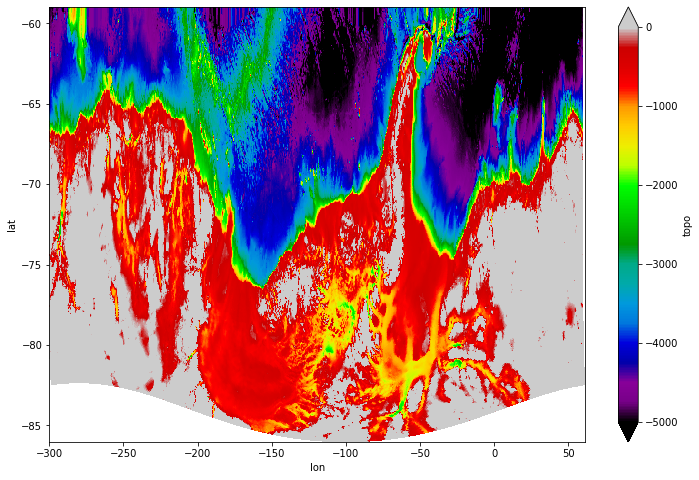

In [29]:
topo_regrid.plot(figsize=[12,8], x='lon', y='lat', cmap='nipy_spectral', vmin=-5000, vmax=0)

In [30]:
h2_regrid = regrid(topo_coarsen['h2'])

In [31]:
%%time

h2_regrid.load()

CPU times: user 79 µs, sys: 2 µs, total: 81 µs
Wall time: 84.4 µs


<xarray.DataArray 'h2' (y: 500, x: 2880)>
array([[ 7.54309273,  7.54309273,  7.32406759, ...,  7.88342714,
         7.88342714,  7.88342714],
       [ 7.81825161,  7.81825161,  7.32406759, ...,  9.77921677,
         7.81825161,  7.81825161],
       [ 7.70697165,  7.70697165,  7.70697165, ...,  7.16895676,
         7.16895676,  7.16895676],
       ...,
       [ 5.38526201,  4.19458294,  7.30517483, ..., 13.23517132,
         6.26044273, 10.63429642],
       [ 7.95001984,  6.96760845,  2.17545366, ...,  7.87615013,
        10.99964046, 16.99850655],
       [ 2.71402979,  6.42533922, 12.5893507 , ...,  8.03525066,
         8.4380579 , 11.1784811 ]])
Coordinates:
    lon      (y, x) float64 -298.6 -298.5 -298.4 -298.2 ... 59.69 59.81 59.94
    lat      (y, x) float64 -82.46 -82.46 -82.45 -82.45 ... -59.01 -59.01 -59.01
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  nearest_s2d

/net2/rnd/anaconda3/envs/analysis/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


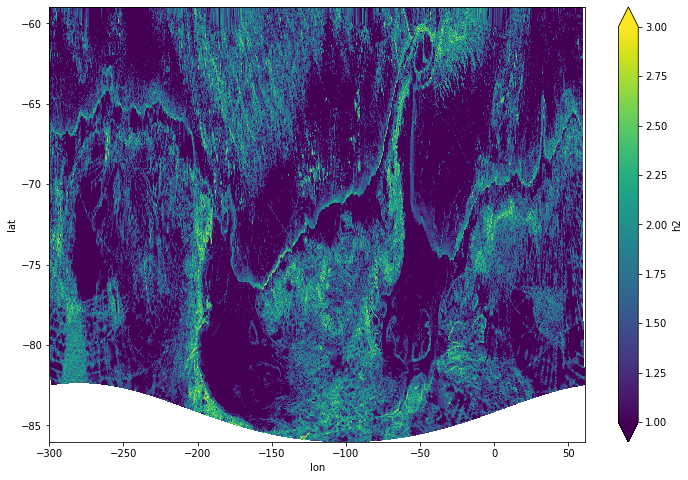

In [32]:
h2_regrid_log = np.log10(h2_regrid)
h2_regrid_log.plot(figsize=[12,8], x='lon', y='lat', vmin=1, vmax=3)